# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives:

At the end of the experiment, you will be able to :

* Understand GAN
* Generate fake images of MNIST dataset

In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_labs/gan.mp4" type="video/mp4">
</video>
""")

## Dataset

###Description

We use the MNIST dataset for this experiment. Below are the details:

1. The dataset contains 60,000 Handwritten digits as training samples and 10,000 Test samples, 
which means each digit occurs 6000 times in the training set and 1000 times in the testing set. (approximately). 
2. Each image is Size Normalized and Centered 
3. Each image is 28 X 28 Pixel with 0-255 Gray Scale Value. 
4. That means each image is represented as 784 (28 X28) dimension vector where each value is in the range 0- 255.

### History

Yann LeCun (Director of AI Research, Facebook, Courant Institute, NYU) was given the task of identifying the cheque numbers (in the 90’s) and the amount associated with that cheque without manual intervention. That is when this dataset was created which raised the bars and became a benchmark.

Yann LeCun and Corinna Cortes (Google Labs, New York) hold the copyright of MNIST dataset, which is a subset of the original NIST datasets. This dataset is made available under the terms of the Creative Commons Attribution-Share Alike 3.0 license. 

It is the handwritten digits dataset in which half of them are written by the Census Bureau employees and remaining by the high school students. The digits collected among the Census Bureau employees are easier and cleaner to recognize than the digits collected among the students.



## Domain Information


Handwriting changes person to person. Some of us have neat handwriting and some have illegible handwriting such as doctors. However, if you think about it even a child who recognizes alphabets and numerics can identify the characters of a text even written by a stranger. But even a technically knowledgeable adult cannot describe the process by which he or she recognizes the text/letters. As you know this is an excellent challenge for Machine Learning.

![altxt](https://i.pinimg.com/originals/f2/7a/ac/f27aac4542c0090872110836d65f4c99.jpg)



## AI / ML Technique

### Generative Adversary Networks (GAN)


GANs are generative models devised by Goodfellow et al. in 2014. GAN is about creating, like drawing a portrait or composing a symphony. This is hard compared to other deep learning fields. For instance, it is much easier to identify a Monet painting than painting one.


The main focus of GAN is to generate data from scratch, mostly images but other domains including music have been done.

GAN composes of two deep networks :

* Generator
* Discriminator


#### Generator 

The generator tries to produce data that come from some probability distribution. For example, that would be you trying to reproduce the party’s tickets.

#### Discriminator

The discriminator acts like a judge. It gets to decide if the input comes from the generator or from the true training set. For example, that would be the party’s security comparing your fake ticket with the true ticket to find flaws in your design.

In summary, we can say that :

* The generator trying to maximize the probability of making the discriminator mistake its inputs as real.

* And the discriminator guiding the generator to produce more realistic images.



![alt text](https://cdn.talentsprint.com/aiml/Experiment_related_data/IMAGES/gan.png)

### Importing required  Packages




In [ ]:
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display

# Pytorch Packages
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

### Loading data

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Deffining the Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

### Defining the Generator Model

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

### Initializing the CUDA

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

### Defining the Optimizer

In [ ]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training Discriminator Function

In [ ]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    # Train on real images
    # Reset gradients
    discriminator.zero_grad()
    prediction_real = discriminator(images)
    
    # Comparing original images 
    real_loss = criterion(prediction_real, real_labels)
    
    # Train on fake images
    prediction_fake = discriminator(fake_images) 
    
    # Comparing fake images
    # Calculate error and backpropagate
    fake_loss = criterion(prediction_fake, fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()

    # Update weights with gradients
    d_optimizer.step()
    return d_loss, prediction_real, prediction_fake

### Training Generator Function

In [ ]:
def train_generator(generator, fake_images, real_labels):
    # Train Generator
    # Reset gradients
    generator.zero_grad()

    # Sample noise and generate fake data
    discriminator_outputs = discriminator(fake_images)

    # Calculate error and backpropagate
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()

    # Update weights with gradients
    g_optimizer.step()
    
    # Return error
    return g_loss

### Generate Samples for Testing

In [ ]:
# Draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = torch.randn(num_test_samples, 100).to(device)

### Lets start training the GAN, in below output the image gets updated for every iteration

**Note:** The below training process for 100 epochs will take around 45 mins to complete the execution.. 

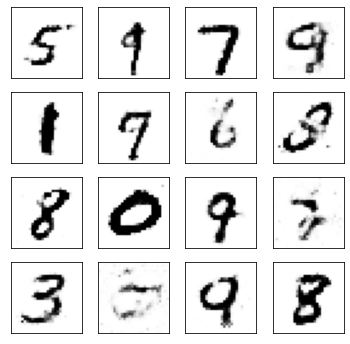

Epoch [100/100], Step[600/600], d_loss: 1.2956, g_loss: 0.9868, D(x): 0.61, D(G(z)): 0.45


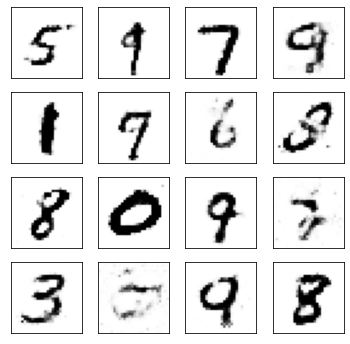

In [ ]:
# Create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Set number of epochs and initialize figure counter
num_epochs = 100    # Change the no of epochs
num_batches = len(train_loader)
num_fig = 0

for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device)
        
        # Sample from generator
        # Generate fake images by passing the random noise vector to the generator
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        
        # Train the discriminator
        d_loss, d_pred_real, d_pred_fake = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator 
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)

        # Train the generator
        g_loss = train_generator(generator, fake_images, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig('results/mnist-gan-%03d.png')
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                    d_pred_real.data.mean(), d_pred_fake.data.mean()))

fig.show()